# 14.2 텍스트 요약(Text Summarization with Attention mechanism)

텍스트 요약은 상대적으로 큰 원문을 핵심 내용만 간추려서 상대적으로 작은 요약문으로 변환하는 것을 말합니다. 읽는 사람이 시간을 단축해서 내용을 빠르게 이해할 수 있다는 점에서 글을 많이 쓰는 사람들에게는 꼭 필요한 능력 중 하나인 것 같습니다. 그런데 만약 기계가 이를 자동으로 해줄 수만 있다면 얼마나 좋을까요? 이번 챕터에서는 그 중 한 가지 방법인 seq2seq를 구현해보겠습니다. 그리고 어텐션 메커니즘(attention mechanism)을 적용해봅시다.

### 1. 텍스트 요약(Text Summarization)
텍스트 요약은 크게 추출적 요약(extractive summarization)과 추상적 요약(abstractive summarization)으로 나뉩니다.

##### 1) 추출적 요약(extractive summarization)
추출적 요약은 원문에서 중요한 핵심 문장 또는 단어구를 몇 개 뽑아서 이들로 구성된 요약문을 만드는 방법입니다. 그렇기 때문에 추출적 요약의 결과로 나온 요약문의 문장이나 단어구들은 전부 원문에 있는 문장들입니다. 추출적 요약의 대표적인 알고리즘으로 머신 러닝 알고리즘인 텍스트랭크(TextRank)가 있는데, 아래의 링크에서 텍스트랭크로 구현된 세 줄 요약기를 시험해볼 수 있습니다.

링크 : https://summariz3.herokuapp.com/

위 링크로 이동하여 인터넷 뉴스나 가지고 있는 글을을 복사 + 붙여넣기하여 결과를 살펴보세요. 세 개의 문장은 전부 원문에 존재하던 문장들입니다. 이 방법의 단점이라면, 이미 존재하는 문장이나 단어구로만 구성하므로 모델의 언어 표현 능력이 제한된다는 점입니다.

그렇다면 마치 사람처럼 원문에 없던 단어나 문장을 사용하면서 핵심만 간추려서 표현하는 요약 방법은 없을까요?

##### 2) 추상적 요약(abstractive summarization)
추상적 요약은 원문에 없던 문장이라도 핵심 문맥을 반영한 새로운 문장을 생성해서 원문을 요약하는 방법입니다. 마치 사람이 요약하는 것 같은 방식인데, 당연히 추출적 요약보다는 난이도가 높습니다. 이 방법은 주로 인공 신경망을 사용하며 대표적인 모델로 seq2seq가 있습니다. 이 방법의 단점이라면 seq2seq와 같은 인공 신경망들은 기본적으로 지도 학습이라는 점입니다. 다시 말해 추상적 요약을 인공 신경망으로 훈련하기 위해서는 '원문' 뿐만 아니라 '실제 요약문'이라는 레이블 데이터가 있어야 합니다. 그렇기 때문에 데이터를 구성하는 것 자체가 하나의 부담입니다. 이번 챕터에서는 이미 공개된 데이터를 사용해서 추상적 요약을 실습해보겠습니다.

### 2. 아마존 리뷰 데이터에 대한 이해
이번 챕터에서 사용할 데이터는 아마존 리뷰 데이터입니다. 아래의 링크에서 데이터를 다운로드합니다.

링크 : https://www.kaggle.com/snap/amazon-fine-food-reviews

우선 실습에 필요한 도구들을 임포트합니다.

In [1]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

##### 1) 데이터 로드하기
Reviews.csv 파일을 불러와 데이터프레임에 저장하겠습니다. 이 데이터는 실제로는 약 56만개의 샘플을 가지고 있습니다. 하지만 여기서는 간단히 10만개의 샘플만 사용하겠습니다. 이는 pd.read_csv의 nrows의 인자로 10만이라는 숫자를 적어주면 됩니다.

In [2]:
df_data = pd.read_csv('../../data/kaggle/amazon-fine-food-reviews.csv', nrows=100000)
print('Review count : ', len(df_data))

Review count :  100000


In [3]:
df_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


5개의 샘플을 출력해보면 'Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'이라는 10개의 열이 존재함을 알 수 있습니다. 그런데 사실 이 중 필요한 열은 'Text'열과 'Summary'열 뿐입니다.

Text열과 Summary열만을 분리하고, 다른 열들은 데이터에서 제외시켜서 재저장합니다. 그리고 5개의 샘플을 출력합니다.

In [4]:
df_data = df_data[['Text', 'Summary']]
df_data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


Text열과 Summary열만 저장된 것을 확인할 수 있습니다. Text열이 원문이고, Summary열이 Text열에 대한 요약입니다. 다시 말해 모델은 Text(원문)으로부터 Summary(요약)을 예측하도록 훈련됩니다. 랜덤으로 샘플 몇 가지를 더 출력해봅시다.

In [5]:
df_data.sample(10)

,Text,Summary
967,OMG I would love these cookies except for the ...,OMG DO NOT BUY!!!
65382,"Celestial Seasonings Green Tea, Antioxidant ty...",Gracious Green Goodness
15141,This is the very best maple syrup you can buy ...,Less water = optimal maple flavor
98122,My 2 year old loves the squeeze applesauce so ...,My toddler would not eat
87501,I tried a few of these then threw the rest awa...,More medicinal taste than vanilla
15344,We had been looking for a healthy waffle mix t...,Perfect Waffle mix
3936,Best coffee ever. Still haven't found anything...,Smooth Brown Wonderfulness!
47459,These are SOOOO good. They are as good if not ...,AWESOME!
86701,Whether you like the basic fruit smoothie or a...,gourmet item at its best
13936,Flamin' Buffalo Chick + A1 are my all time fav...,Love it! But huge on sodium though.


여기서는 data.sample(10)를 한 번만 실행했지만 지속적으로 몇 차례 더 실행하면서 샘플의 구조를 확인해보세요. 원문은 꽤 긴 반면에, Summary에는 3~4개의 단어만으로 구성된 경우도 많아보입니다.

##### 2) 데이터 정제하기
데이터에 중복 샘플이 있는지 확인해보겠습니다.

In [6]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
Text       100000 non-null object
Summary    99998 non-null object
dtypes: object(2)
memory usage: 1.5+ MB


In [7]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', df_data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', df_data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


전체 데이터는 10만개의 샘플이 존재하지만, 실제로는 꽤 많은 원문이 중복되어 중복을 배제한 유일한 원문의 개수는 88,426개입니다. 중복 샘플이 무려 약 1,200개나 있다는 의미지요. Summary는 중복이 더 많지만, 원문은 다르더라도 짧은 문장인 요약은 내용이 겹칠 수 있음을 가정하고 일단 두겠습니다. Summary의 길이 분포는 뒤에서 확인하겠습니다.

In [8]:
df_data.drop_duplicates(subset=['Text'], inplace=True)

In [9]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88426 entries, 0 to 99999
Data columns (total 2 columns):
Text       88426 non-null object
Summary    88425 non-null object
dtypes: object(2)
memory usage: 2.0+ MB


Summary에서 1개의 Null data 가 존재함

In [10]:
df_data.dropna(axis=0, inplace=True)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88425 entries, 0 to 99999
Data columns (total 2 columns):
Text       88425 non-null object
Summary    88425 non-null object
dtypes: object(2)
memory usage: 2.0+ MB


이제 남은 샘플 수는 88,425개입니다. 지금까지는 불필요한 샘플의 수를 줄이기 위한 정제 과정이었습니다. 이제 샘플 내부를 전처리해야 합니다. 단어 정규화와 불용어 제거를 위해 각각의 참고 자료가 필요합니다. 동일한 의미를 가졌지만 스펠링이 다른 단어들을 정규화하기 위한 사전을 만듭니다. 이 사전은 아래의 링크를 참고하여 만들어진 사전입니다.

링크 : https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [11]:
# 전처리 함수 내 사용
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

NLTK의 불용어를 저장하고 개수를 확인

In [12]:
stop_words = set(stopwords.words('english'))
print('Count of Stop word : ', len(stop_words))
print(stop_words)

Count of Stop word :  179
{'our', 'were', 'so', 'for', 'against', "shouldn't", 'them', 'its', 'at', 'theirs', 'than', 'hadn', "she's", 'been', 'both', 'about', 'you', "you'll", 'very', "mightn't", 'before', 'needn', 'mightn', 'ourselves', 'while', 'she', 'being', 'why', "didn't", 'hasn', 'wasn', 'himself', 'most', 'won', 'weren', 'no', "that'll", "hasn't", 'such', 'did', 'should', 'there', 'haven', 'these', 'o', 'between', "it's", 'by', 'only', 'wouldn', 'from', 'didn', 'doesn', 'where', 'i', 'the', 'mustn', 'that', 'few', 'which', 'all', "mustn't", "won't", 'me', 'my', 're', 'm', 'he', 'it', 'themselves', "wouldn't", 'we', 'above', 'have', 'now', "don't", 'be', 'too', "should've", 'can', 'yours', 'again', 'each', 'isn', 'y', 'him', 'after', 'having', 'is', 'because', 'd', 'herself', 'ma', 'up', 'nor', "isn't", "you've", 'then', 'same', "haven't", 'any', 'when', 'own', 'are', "couldn't", 'and', 'this', 'through', 'doing', 'on', 'does', 'here', 'am', 'had', 'couldn', 'shan', 'or', 'will

전처리 함수를 설계합니다.

In [13]:
def preprocess_sentence(sentence, remove_stopwords=True):
    # to lower case
    sentence = sentence.lower()
    #print('\nTo lower case\n', sentence)
    
    # Remove html tags
    sentence = BeautifulSoup(sentence, 'lxml').text
    #print('\nRemove html tags\n', sentence)
    
    # 괄호로 닫힌 문자열 제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub(r'\([^)]*\)', '', str(sentence))
    #print('\nRemove with parentheses\n', sentence)
    
    # 쌍따옴표 제거
    sentence = re.sub('"', '', sentence)
    #print('\nRemove double quotation\n', sentence)
    
    # 약어 정규화
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    #print('\nNormalization of abbreviation\n', sentence)
    
    # 소유격 제거   Ex) roland's -> roland
    sentence = re.sub(r"'s\b", '', sentence)
    #print('\nRemove possessive\n', sentence)
    
    # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    #print('\nConvert non-English  character  to spaces\n', sentence)
    
    # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    sentence = re.sub('[m]{2,}', 'mm', sentence)
    #print('\nIf there are more than 3 ms, change to 2\n', sentence)
    
    # 불용어 제거
    if remove_stopwords:
        tkns = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
        #print('\nRemove Stopwords\n', sentence)
    # 불용어 미제거(Summary)
    else:
        tkns = ' '.join(word for word in sentence.split() if len(word) > 1)
        #print('\nRemain Stopwords\n', sentence)
    return tkns  

In [14]:
x = 'my option ( xyz  ) is good'
x = re.sub(r'\([^)]*\)', '', x)
print(x)

my option  is good


함수 내부의 각 줄에 주석을 달았으므로 자세한 설명은 생략하겠습니다. 여기서는 Text 열에서는 불용어를 제거하고, Summary 열에서는 불용어를 제거하지 않기로 결정했습니다. Summary를 입력으로 할 때는 두번째 인자를 0으로 줘서 불용어를 제거하지 않는 버전을 실행하겠습니다. 임의의 Text 문장과 Summary 문장을 만들어 전처리 함수를 통한 전처리 후의 결과를 확인해보겠습니다.

In [15]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary,0))

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


우선 Text 열에 대해서 전처리를 수행하겠습니다. 전처리 후에는 5개의 전처리 된 샘플을 출력합니다.

In [16]:
clean_text = []

for s in df_data['Text']:
    clean_text.append(preprocess_sentence(s))
clean_text[:5]    

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

이제 Summary 열에 대해서 전처리를 수행하겠습니다. 전처리 후에는 5개의 전처리 된 샘플을 출력합니다.

In [17]:
# summary
clean_summary =[]
for s in df_data['Summary']:
    clean_summary.append(preprocess_sentence(s,0))
clean_summary[:5]    

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:282: UserWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

In [18]:
df_data['Text'] = clean_text
df_data['Summary'] = clean_summary

혹시 전처리 과정에서 빈 값이 생겼다면 Null 값으로 변경한 후에 Null 값을 가진 샘플이 생겼는지 확인합니다.

In [19]:
df_data.replace('', np.nan, inplace=True)
print(df_data.isnull().sum())

Text        0
Summary    70
dtype: int64


Summary 열에서 70개의 샘플이 Null 값을 가집니다. 이 샘플들을 제거해주고, 전체 샘플수를 확인합니다.

In [20]:
df_data.dropna(axis=0,inplace = True)
print('Total sample count : ', len(df_data))

Total sample count :  88355


이제 Text 열과 Summary 열에 대해서 길이 분포를 확인해보겠습니다.



Min length of Text  : 2
Max length of Text  : 1235
Average length of Text  : 38.792428272310566
Min length of Summary  : 1
Max length of Summary: 28
Average length of Summary: 4.010729443721352


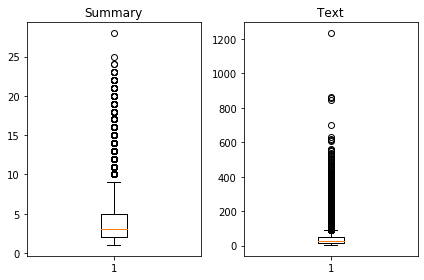

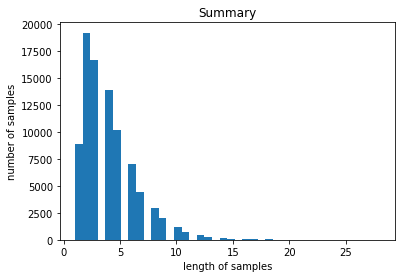

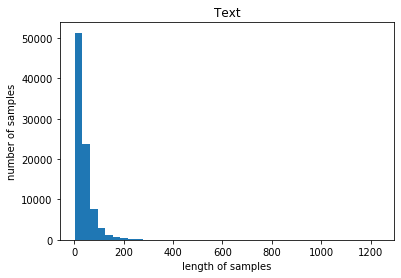

In [21]:
# 길이 분포 출력
text_len  = [ len(s.split()) for s in df_data['Text']]
summary_len = [len(s.split()) for s in df_data['Summary']]

print('Min length of Text  : {}'.format(np.min(text_len)))
print('Max length of Text  : {}'.format(np.max(text_len)))
print('Average length of Text  : {}'.format(np.mean(text_len)))
print('Min length of Summary  : {}'.format(np.min(summary_len)))
print('Max length of Summary: {}'.format(np.max(summary_len)))
print('Average length of Summary: {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

원문 텍스트는 대체적으로 100이하의 길이를 가집니다. 또한, 평균 길이는 38입니다. 요약의 경우에는 대체적으로 15이하의 길이를 가지며 평균 길이는 4입니다. 여기서 패딩의 길이를 정하겠습니다. 평균 길이보다는 크게 잡아 각각 50과 8로 결정합니다.

In [22]:
text_max_len = 50
summary_max_len = 8

50과 8이라는 이 두 길이가 얼마나 많은 샘플들의 길이보다 큰지 확인해보겠습니다.



In [23]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        #print('\ns:\n',s, '\ns.split\n', s.split())
        if (len(s.split()) <= max_len ):
            cnt += 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s' %(max_len, (cnt/len(nested_list))))          

In [24]:
below_threshold_len(text_max_len, df_data['Text'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859


Text 열은 길이가 50 이하인 비율이 77%입니다. 약 23%의 샘플이 길이 50보다 큽니다. Summary 열에 대해서 확인해봅시다.

In [25]:
below_threshold_len(summary_max_len, df_data['Summary'])

전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


Summary 열은 길이가 8 이하인 경우가 94%입니다. 여기서는 정해준 최대 길이보다 큰 샘플들은 제거하겠습니다.

In [26]:
df_data = df_data[df_data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
df_data = df_data[df_data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]

print('Total samples count : ', len(df_data))

Total samples count :  65818


이제 샘플수가 65,818개로 줄었습니다. 정제 작업이 완료된 상위 샘플 5개를 출력해봅시다.

In [27]:
df_data.head()

,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,confection around centuries light pillowy citr...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great taffy great price wide assortment yummy ...,great taffy


seq2seq 훈련을 위해서는 디코더의 예측 대상에 시작 토큰과 종료 토큰을 추가할 필요가 있습니다. 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 명명하고 앞, 뒤로 추가하겠습니다.

In [28]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
df_data['Summary'] = df_data['Summary'].apply(lambda x : 'sostoken ' + x + ' eostoken')
df_data.head()

,Text,Summary
0,bought several vitality canned dog food produc...,sostoken good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,sostoken not as advertised eostoken
2,confection around centuries light pillowy citr...,sostoken delight says it all eostoken
3,looking secret ingredient robitussin believe f...,sostoken cough medicine eostoken
4,great taffy great price wide assortment yummy ...,sostoken great taffy eostoken


이를 각각 Text_data와 Summary_data로 저장하겠습니다.

In [29]:
text_data = list(df_data['Text'])
summary_data = list(df_data['Summary'])

### 3) 데이터의 분리
훈련 데이터와 테스트 데이터를 분리해봅시다

In [30]:
from sklearn.model_selection import train_test_split

x_train,x_test, y_train, y_test = train_test_split(text_data, summary_data, test_size=0.2, random_state=0, shuffle=True)

print('Count of train data : ', len(x_train))
print('Count of train label data : ', len(y_train))
print('Count of test data : ', len(x_test))
print('Count of test label data : ', len(y_test))

Count of train data :  52654
Count of train label data :  52654
Count of test data :  13164
Count of test label data :  13164


##### 4) 정수 인코딩
이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 합니다. 훈련 데이터에 대해서 단어 집합(vocaburary)을 만들어봅시다. 우선, 원문에 해당되는 X_train에 대해서 수행합니다

In [31]:
src_tkn = Tokenizer()
src_tkn.fit_on_texts(x_train)

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었습니다. 이는 src_tokenizer.word_index에 저장되어져 있습니다. 여기서는 빈도수가 낮은 단어들은 자연어 처리에서 배제하고자 합니다. 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.

In [32]:
threshold = 7
total_cnt = len(src_tkn.word_index) # 단어의 수
rare_cnt = 0  # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0  # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0  # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tkn.word_counts.items():
    total_freq += value
    
    # 단어의 등장 빈도수가 threshold.보다 작으면
    if(value < threshold):
        rare_cnt += 1
        rare_freq += value
        
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)        

단어 집합(vocabulary)의 크기 : 31940
등장 빈도가 6번 이하인 희귀 단어의 수: 23707
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8233
단어 집합에서 희귀 단어의 비율: 74.22354414527238
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.3949897589412323


등장 빈도가 threshold 값인 7회 미만. 즉, 6회 이하인 단어들은 단어 집합에서 무려 70% 이상을 차지합니다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.39%밖에 되지 않습니다. 여기서는 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 배제시키고자 합니다. 위에서 이를 제외한 단어 집합의 크기를 8,233으로 계산했는데, 저자는 깔끔한 값을 선호하여 이와 비슷한 값으로 단어 집합의 크기를 8000으로 제한하겠습니다.

In [33]:
src_vc = 8000
src_tknr = Tokenizer(num_words = src_vc)
src_tknr.fit_on_texts(x_train)

x_train = src_tknr.texts_to_sequences(x_train)
x_test = src_tknr.texts_to_sequences(x_test)

In [34]:
print(x_train[:5])

[[4256, 611, 816, 4477, 528, 1540, 32, 45, 4, 79, 2281, 234, 19, 1157, 2923, 948, 1122, 996, 2, 153, 10, 43], [204, 15, 154, 51, 259, 60, 73, 24, 49, 17, 886, 259, 2, 29, 209, 14, 504, 2081, 420, 13, 86, 64, 22, 2464, 134, 14, 504, 86], [112, 1570, 2, 1771, 185, 39, 505, 112, 283], [296, 105, 496, 834, 69, 103, 334, 5082, 2294, 765, 7, 908, 585, 1489, 351, 5265, 100, 75, 1908, 137, 141, 585, 864, 5083, 89, 830, 564, 1772, 305, 254, 1541, 97, 247, 2, 1600, 2100, 92, 2645], [54, 1247, 806, 5, 497, 479, 46, 236, 1218, 381, 5, 3879, 3880, 172, 479, 46, 1247]]


In [35]:
tgt_tknr = Tokenizer()
tgt_tknr.fit_on_texts(y_train)

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었습니다. 이는 tar_tokenizer.word_index에 저장되어져 있습니다. 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.

In [36]:
threshold = 6
total_cnt = len(tgt_tknr.word_index)  # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0  # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

for key, value in tgt_tknr.word_counts.items():
    total_freq += value
    
    if (value < threshold):
        rare_cnt += 1
        rare_freq += value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)        

단어 집합(vocabulary)의 크기 : 10498
등장 빈도가 5번 이하인 희귀 단어의 수: 8126
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2372
단어 집합에서 희귀 단어의 비율: 77.40522004191274
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.833194065065198


등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 77%를 차지합니다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 4.83%밖에 되지 않습니다. 이 단어들은 정수 인코딩 과정에서 배제시키겠습니다.

In [37]:
tgt_vc = 2000
tgt_tknr = Tokenizer(num_words = tgt_vc)
tgt_tknr.fit_on_texts(y_train)

y_train = tgt_tknr.texts_to_sequences(y_train)
y_test = tgt_tknr.texts_to_sequences(y_test)

In [38]:
print(y_train[:5])

[[1, 805, 2], [1, 7, 298, 138, 86, 2], [1, 25, 745, 2], [1, 488, 39, 22, 30, 12, 2], [1, 15, 16, 238, 84, 35, 12, 2]]


##### 5) 빈 샘플(empty samples) 제거
전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었다는 것을 의미합니다. 이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 4밖에 되지 않았던 요약문(Summary)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높습니다. 요약문에서 길이가 0이 된 샘플들의 인덱스를 받아옵시다. 주의할 점은 요약문에는 sostoken과 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플수와 동일하여 단어 집합 제한에도 삭제 되지 않습니다. 그래서 이제 길이가 0이 된 요약문의 실질적 길이는 2입니다.

In [39]:
drop_train = [index for index, sentence in enumerate(y_train) if len(sentence) ==2]
drop_test = [ index for index, sentence in  enumerate(y_test) if len(sentence) ==2]

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 2인 경우의 인덱스를 각각 drop_train과 drop_test에 저장하였습니다. 삭제 전의 훈련 데이터와 테스트 데이터의 개수를 출력해봅시다.

In [40]:
print('훈련 데이터의 개수 :', len(x_train))
print('훈련 레이블의 개수 :',len(y_train))
print('테스트 데이터의 개수 :',len(x_test))
print('테스트 레이블의 개수 :',len(y_test))

훈련 데이터의 개수 : 52654
훈련 레이블의 개수 : 52654
테스트 데이터의 개수 : 13164
테스트 레이블의 개수 : 13164


삭제 후의 개수는 다음과 같습니다.

In [41]:
x_train = np.delete(x_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
x_test = np.delete(x_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(x_train))
print('훈련 레이블의 개수 :',len(y_train))
print('테스트 데이터의 개수 :',len(x_test))
print('테스트 레이블의 개수 :',len(y_test))

훈련 데이터의 개수 : 51404
훈련 레이블의 개수 : 51404
테스트 데이터의 개수 : 12813
테스트 레이블의 개수 : 12813


##### 6) 패딩하기
훈련 데이터와 테스트 데이터에 대해서 패딩 작업을 수행합니다. 이미 앞서 정해둔 최대 길이를 넘는 샘플들은 제외했기 때문에 따로 길이 분포를 재확인하지는 않겠습니다.

In [42]:
x_train = pad_sequences(x_train, maxlen = text_max_len, padding='post')
x_test = pad_sequences(x_test, maxlen = text_max_len, padding='post')
y_train = pad_sequences(y_train, maxlen = summary_max_len, padding='post')
y_test = pad_sequences(y_test, maxlen = summary_max_len, padding='post')

### 3. seq2seq + attention으로 요약 모델 설계 및 훈련시키기

In [43]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

인코더를 설계해보겠습니다. 인코더는 LSTM 층을 3개 쌓습니다.


In [52]:
embedding_dim = 128
hidden_size = 256

# encoder
encoder_inputs = Input(shape=(text_max_len,))

# Embedding Layer of encoder
enc_emb = Embedding(src_vc, embedding_dim)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(hidden_size,  return_sequences = True, return_state = True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(hidden_size,  return_sequences = True, return_state = True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(hidden_size,  return_sequences = True, return_state = True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

디코더를 설계해보겠습니다. 단, 출력층은 제외하고 설계하겠습니다. 디코더의 설계는 인코더와 사실상 동일하지만 초기 상태(initial_state)를 인코더의 상태로 주어야 하는 것에 주의합시다.

In [53]:
# Decoder
decoder_inputs = Input(shape=(None,))

# Embedding Layer of decoder
dec_emb = Embedding(tgt_vc, embedding_dim)(decoder_inputs)

# LSTM of Decoder
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout =0.4, recurrent_dropout=0.2)
decoder_outputs,_,_ = decoder_lstm(dec_emb, initial_state = [ state_h, state_c])

이제 디코더의 출력층을 설계합니다.

In [54]:
# Output layer of decoder
decoder_softmax_layer = Dense(tgt_vc, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# Define Model
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 128)      1024000     input_5[0][0]                    
__________________________________________________________________________________________________
unified_lstm_4 (UnifiedLSTM)    [(None, 50, 256), (N 394240      embedding_3[0][0]                
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

model.summary() 결과는 지면의 한계로 여기에 올리지 않겠습니다. 총 3,633,104개의 매개변수를 가진 seq2seq 모델이 설계됩니다. 지금까지의 모델 설계는 앞서 seq2seq 챕터에서 배웠던 내용과 동일합니다.

그런데 이번 챕터에서는 어텐션 메커니즘을 사용할 예정이므로 위에서 설계한 출력층을 사용하지 않고, 어텐션 메커니즘이 결합된 새로운 출력층을 설계해보겠습니다. 어텐션 함수를 직접 작성하지 않고 이미 깃허브에 공개된 함수를 사용할 것이므로 아래의 코드를 통해 attention.py 파일을 다운로드하고, AttentionLayer를 임포트합니다.

In [55]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/layers/attention.py", filename="attention.py")

from attention import AttentionLayer

어텐션 메커니즘을 이용해 디코더의 출력층을 새롭게 설계합니다.



In [56]:
# Attention Layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Attention결과와 Decoder hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# Decoder output layer
decoder_softmax_layer = Dense(tgt_vc, activation='softmax')
deocder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# Define Model
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 128)      1024000     input_5[0][0]                    
__________________________________________________________________________________________________
unified_lstm_4 (UnifiedLSTM)    [(None, 50, 256), (N 394240      embedding_3[0][0]                
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

총 4,276,432개의 파라미터를 가진 모델이 설계됩니다. 이제 모델을 컴파일합니다.



In [57]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

조기 종료 조건을 설정하고 모델을 학습시킵니다.

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
history = model.fit([x_train, y_train[:,:-1]] \
                    , y_train.reshape(y_train.shape[0], y_train.shape[1],1)[:,1:] \
                    , epochs =50, callbacks=[es], batch_size=256 \
                    , validation_data =([x_test, y_test[:,:-1]] \
                    , y_test.reshape(y_test.shape[0],y_test.shape[1],1)[:,1:]))

Train on 51404 samples, validate on 12813 samples
Epoch 1/50
51404/51404 [==============================] - 857s 17ms/sample - loss: 3.0592 - val_loss: 2.7562
Epoch 2/50
51404/51404 [==============================] - 843s 16ms/sample - loss: 2.7252 - val_loss: 2.6584
Epoch 3/50
51404/51404 [==============================] - 734s 14ms/sample - loss: 2.5894 - val_loss: 2.5165
Epoch 4/50
51404/51404 [==============================] - 809s 16ms/sample - loss: 2.4738 - val_loss: 2.4293
Epoch 5/50
51404/51404 [==============================] - 895s 17ms/sample - loss: 2.3896 - val_loss: 2.3637
Epoch 6/50
51404/51404 [==============================] - 820s 16ms/sample - loss: 2.3170 - val_loss: 2.3034
Epoch 7/50
51404/51404 [==============================] - 785s 15ms/sample - loss: 2.2558 - val_loss: 2.2628
Epoch 8/50
51404/51404 [==============================] - 893s 17ms/sample - loss: 2.2091 - val_loss: 2.2320
Epoch 9/50
51404/51404 [==============================] - 904s 18ms/sample - l

학습 과정하면서 기록된 훈련 데이터의 손실과 테스트 데이터의 손실 히스토리를 시각화하여 출력합니다

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.legend()
plt.show()

테스트 데이터의 손실이 지속적으로 줄어들다가 어느 순간부터 정체하게 됩니다.

### 4. seq2seq + attention으로 요약 모델 테스트하기
테스트를 위해 필요한 3개의 사전을 만듭니다.

In [ ]:
src_index_to_word = src_tknr.index_word
tgt_word_to_index = tgt_tknr.word_index
tgt_index_to_word = tgt_tknr.index_word

seq2seq는 훈련 단계와 테스트 단계의 동작이 다르므로 테스트 단계의 모델을 별도로 다시 설계해줄 필요가 있습니다. 다시 새로운 seq2seq 모델을 만들겠습니다. 우선 인코더를 정의합니다.

In [ ]:
# Design encoder
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

이제 테스트 단계의 디코더를 설계합니다.



In [ ]:
# 이전 시스템의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2= dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.

decoder_outputs2, state_h2, state_c2 = \
    decoder_lstm(des_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [46]:
# Attention function
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])

# Decoder's output layer
decoder_outputs2= decoder_softmax_layer(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
            [decoder_inputs] 
            + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c]
            , [decoder_outputs2] + [state_h2, state_c2]
        )

NameError: name 'attn_layer' is not defined

테스트 단계를 위한 모델이 완성되었습니다. 테스트를 위해 사용되는 함수 decode_sequence를 설계합니다.

In [ ]:
def decode_sequence(input_seq):
    # 입력으로 부터 인코더의 상태를 얻음
    states_values = encoder_model.predict(input_seq)
    # SOS에 해당하는 원핫 백터 생성
    tgt_seq = np.zeros((1,1,tgt_vc_size))
    tgt_seq[0,0, tgt_to_index['\t']] =1.
    
    stop_condition = False
    decoded_sentence =''
    
    while not stop_condition:
        # 이전 시점의 상태 sates_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([tgt_seq]+sates_value)
        sampled_tkn_index = np.argmax(output_tkns[0,-1,:])
        sampled_char = index_to_tgt[sampled_tkn_index]
        decoded_sentence += sampled_char
        
        # eos에 도달하거나 최대 길이를 넘으면 중단
        if (sampled_char =='\n' or
           len(decoded_sentence) > max_tgt_len):
            stop_condition= True
            
        # 길이가 1인 타켓 시퀀스를 업데이트
        tgt_seq = np.zeros((1,1,tgt_vc_size))
        tgt_seq[0,0,sampled_tkn_index] =1.
        
        # 상태를 업데이트
        states_value =[ h,c]
        
    return decoded_sentence

테스트 단계에서 원문과 실제 요약문, 예측 요약문을 비교하기 위해 정수 시퀀스를 텍스트 시퀀스로 만드는 함수를 설계합니다.

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp = ''
    for i in input_seq:
        if(i !=0):
            temp += src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if((i != 0 and i != tgt_word_index['sostoken']) 
           and i != tgt_word_index['eostoken']):
            temp += tgt_index_to_word[i] + ' '
    return temp
            

테스트 샘플 중 500번부터 1000번까지 테스트해봅시다.

In [ ]:
for i in reange(500, 1000):
    print('원문 : ', seq2text(x_test[i]))
    print('실제 요약문 : ', seq2summary(x_test[i]))
    print('예측요약문 : ', decode_sequence(x_test[i].reshape(1, text_max_len)))
    print('\n')

실제 요약문과 완전히 똑같지 않으면서 원문의 맥락을 잘 잡아서 예측된 요약문들이 존재하는 것을 확인할 수 있습니다.